https://stackoverflow.com/questions/73365651/instability-in-fitting-data-using-scipy-optimize-library

x(t) = - B + sqrt(AB(t-t0) + (x0 + B)^2)

In [1]:
import io
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt

In [153]:
stream = io.StringIO("""Time,x
201,2.67662
204,3.28159
206,3.44378
208,3.72537
210,3.94826
212,4.36716
214,4.65373
216,5.26766
219,5.59502
221,6
223,6.22189
225,6.49652
227,6.799
229,7.30846
231,7.54229
232,7.76517
233,7.6209
234,7.89552
235,7.94826
236,8.17015
237,8.66965
238,8.66965
239,8.8398
240,8.88856
241,9.00697
242,9.45075
243,9.51642
244,9.63483
245,9.63483
246,10.07861
247,10.02687
248,10.24876
249,10.31443
250,10.47164
251,10.99502
252,10.92935
253,11.0995
254,11.28358
255,11.58209
256,11.53035
257,11.62388
258,11.93632
259,11.98806
260,12.26269
261,12.43284
262,12.60299
263,12.801
264,12.99502
265,13.08557
266,13.25572
267,13.32139
268,13.57114
269,13.76617
270,13.88358
271,13.83184
272,14.10647
273,14.27662
274,14.40796""")
data = pd.read_csv(stream)

In [154]:
data = data.sub(data.iloc[0,:])
#data = data.div(data.max(axis=0), axis=1)
data = data.set_index("Time")
data.sample(5)

,x
Time,
22.0,3.54527
33.0,5.21890
60.0,9.75622
49.0,7.79502
47.0,7.57214


In [97]:
def model(t, A, B):
    return -B + np.sqrt(A*B*t + np.power(B, 2))

In [151]:
def model(t, C, B, scale=1):
    return -B*scale + np.sqrt(C*t + np.power(B*scale, 2))

In [152]:
t = np.linspace(0, 1000, 100)
x = model(t, 0.35*20, 20*0.1)
data = pd.DataFrame(x, index=t, columns=["x"])
data.sample(5)

,x
676.767677,66.857634
545.454545,59.823797
888.888889,76.906414
585.858586,62.070353
969.696970,80.412856


<AxesSubplot:xlabel='Time'>

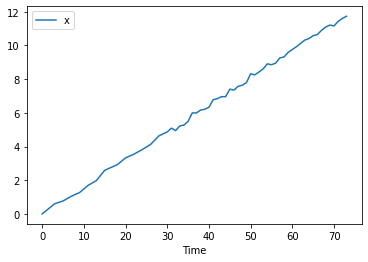

In [155]:
data.plot()

In [156]:
tlin = np.linspace(data.index.min(), data.index.max(), 1000)

In [157]:
parameters, covariance = optimize.curve_fit(model, data.index, data["x"].values, p0=(1, 100), ftol=1e-8)

In [159]:
parameters

array([22303.70911882, 68962.46009323])

In [161]:
parameters[0]/parameters[1]

0.3234181189109134

In [160]:
print(covariance)

[[2.12476053e+11 6.57012287e+11]
 [6.57012287e+11 2.03159435e+12]]


In [162]:
np.sqrt(covariance)

array([[ 460951.24756324,  810562.94443004],
       [ 810562.94443004, 1425340.08323072]])

In [132]:
def taylor(t, A, B):
    return (A/2*t - A**2/B*t**2/8) 

In [131]:
#parameters, covariance = optimize.curve_fit(taylor, data.index, data["x"].values, p0=(1, 100), ftol=1e-8)
#parameters

In [137]:
y = data.iloc[:,0].values
y_fit = model(data.index.values, *parameters)

In [138]:
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - (ss_res / ss_tot)

In [139]:
r2

1.0

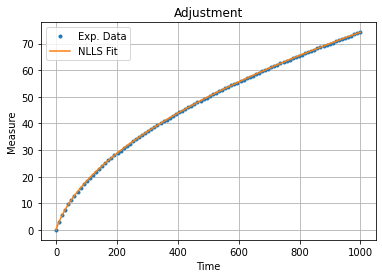

In [140]:
axe = data.plot(linestyle="none", marker=".")
axe.plot(tlin, model(tlin, *parameters))
#axe.plot(tlin, model(tlin, *(parameters[0], 1e7)))
axe.set_title("Adjustment")
axe.set_xlabel("Time")
axe.set_ylabel("Measure")
axe.legend(["Exp. Data", "NLLS Fit"])
axe.grid()

In [163]:
def objective(beta, t, x):
    return np.sum(np.power(model(t, beta[0], beta[1]) - x, 2))

In [164]:
result = optimize.minimize(objective, (1, 0), args=(data.index, data["x"].values), tol=1e-8)

In [165]:
result

      fun: 1.3621054440846505
 hess_inv: array([[ 0.00229279, -0.00140919],
       [-0.00140919,  0.00149551]])
      jac: array([ 0.1506872 , -0.04942749])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 183
      nit: 27
     njev: 60
   status: 2
  success: False
        x: array([ 650.44073292, 1977.91892548])

In [166]:
a = np.linspace(0.25, 0.40, 200)
a = np.linspace(5, 10, 200)
#a = np.linspace(0.5, 1.0, 200)
a = np.linspace(100, 2000, 200)
b = np.logspace(1, 4, 200, base=10)
b = np.linspace(10, 30, 200)
b = np.linspace(1.0, 3.0, 200)
b = np.linspace(1500, 2500, 200)
A, B = np.meshgrid(a, b)

In [167]:
Z = np.full(A.shape, np.nan)

In [168]:
for i, a_ in enumerate(a):
    for j, b_ in enumerate(b):
        Z[j,i] = objective((a_, b_), data.index, data["x"].values)

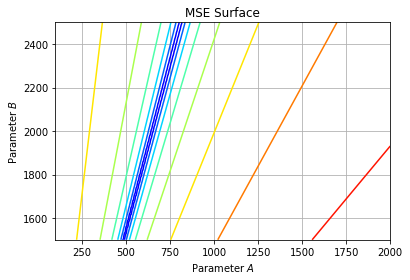

In [169]:
fig, axe = plt.subplots()
axe.contour(A, B, np.log10(Z), cmap="jet")
axe.set_title("MSE Surface")
axe.set_xlabel("Parameter $A$")
axe.set_ylabel("Parameter $B$")
#axe.set_ylim([10, 30])
#axe.set_yscale("log")
axe.grid()